# Продажи австралийского вина

In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
%pylab inline

from matplotlib import rc
rc('font',**{'family':'serif', 'size':70})
rc('text', usetex=True)
rc('text.latex',unicode=True)
rc('text.latex',preamble='\usepackage[utf8]{inputenc}')
rc('text.latex',preamble='\usepackage[russian]{babel}')

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/Users/emily/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие два года.

In [2]:
wine = pd.read_csv('monthly-australian-wine-sales.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
wine.sales = wine.sales * 1000
#plt.figure(figsize(30,15))
#wine.sales.plot(fontsize=40, linewidth=4.0)
#plt.xlabel(u'Месяц', fontsize=60)
#plt.ylabel(u'Объём продаж вина', fontsize=60)

Проверка стационарности и STL-декомпозиция ряда:

In [4]:
plt.figure(figsize(30,30))
#sm.tsa.seasonal_decompose(wine.sales).plot()
print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(wine.sales)[1]

Критерий Дики-Фуллера: p=0.051161


Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

### Стабилизация дисперсии

In [5]:
wine['sales_box'], lmbda = stats.boxcox(wine.sales)
#plt.figure(figsize(30,15))
#wine.sales_box.plot(fontsize=40, linewidth=4.0)
#plt.xlabel(u'Месяц', fontsize=60)
#plt.ylabel(u'Преобразованные продажи вина', fontsize=60)
#print "Оптимальный параметр преобразования Бокса-кокса: %f" % lmbda
#print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(wine.sales_box)[1]

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

In [6]:
wine['sales_box_diff'] = wine.sales_box - wine.sales_box.shift(12)
#plt.figure(figsize(30,30))
#sm.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot()
#print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(wine.sales_box_diff[12:])[1]

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

In [7]:
wine['sales_box_diff2'] = wine.sales_box_diff - wine.sales_box_diff.shift(1)
#plt.figure(figsize(30,30))
#sm.tsa.seasonal_decompose(wine.sales_box_diff2[13:]).plot()   
#print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(wine.sales_box_diff2[13:])[1]

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

In [3]:
plt.figure(figsize(30,20))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

AttributeError: 'DataFrame' object has no attribute 'sales_box_diff2'

Error in callback <function post_execute at 0x1158200c8> (for post_execute):


RuntimeError: LaTeX was not able to process the following string:
'lp'
Here is the full report generated by LaTeX: 



RuntimeError: LaTeX was not able to process the following string:
'lp'
Here is the full report generated by LaTeX: 



Начальные приближения: Q=1, q=2, P=1, p=4

In [8]:
Ps = range(0, 3)
ps = range(0, 6)
Qs = range(0, 3)
qs = range(0, 4)

In [19]:
?sm.tsa.statespace.SARIMAX

In [24]:
model=sm.tsa.statespace.SARIMAX(wine.sales_box, order=(2, 1, 1), seasonal_order=(0, 1, 1, 12)).fit(disp=-1)

In [26]:
m=sm.tsa.statespace.SARIMAX(wine.sales_box, order=(2, 1, 1), seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
m.aic

1007.801553201779

In [25]:
model.aic

1007.801553201779

## grid search (begin)

In [12]:
from itertools import product

In [27]:
parameters = product(ps, qs, Ps, Qs)

In [28]:
#не обязательно, со спиком удобнее отлаживать, чем с генератором, можно много раз по нему пройтись
parameters_list = list(parameters)
len(parameters_list)

In [57]:
%%time
results = []
best_aic = 0
#берем первые 10 наборов значений
for param in parameters_list[:10]:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wine.sales_box, order=(param[0], 1, param[1]), 
                                    seasonal_order=(param[2], 1, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic > best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 0, 0)
CPU times: user 8.77 s, sys: 131 ms, total: 8.9 s
Wall time: 4.54 s


In [58]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']

In [59]:
result_table

,parameters,aic
0,"(0, 0, 0, 1)",1112.788356
1,"(0, 0, 0, 2)",1107.014557
2,"(0, 0, 1, 0)",1125.322797
3,"(0, 0, 1, 1)",1106.572515
4,"(0, 0, 1, 2)",1108.559008
5,"(0, 0, 2, 0)",1118.791862
6,"(0, 0, 2, 1)",1108.561118
7,"(0, 0, 2, 2)",1109.700197
8,"(0, 1, 0, 0)",1045.929356


In [60]:
best_param

(0, 0, 1, 0)

In [61]:
best_aic

1125.3227973223029

In [63]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -560.661
Date:                            Fri, 16 Sep 2016   AIC                           1125.323
Time:                                    21:31:45   BIC                           1131.664
Sample:                                01-01-1980   HQIC                          1127.895
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2937      0.074     -3.960      0.000      -0.439      -0.148
sigma2        56.5275      5.009   

## grid search (end)

Лучшая модель:

In [95]:
print model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -498.901
Date:                            Wed, 14 Sep 2016   AIC                           1007.802
Time:                                    13:56:15   BIC                           1023.654
Sample:                                01-01-1980   HQIC                          1014.231
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111   

Её остатки:

Критерий Стьюдента: p=0.257989
Критерий Дики-Фуллера: p=0.000000


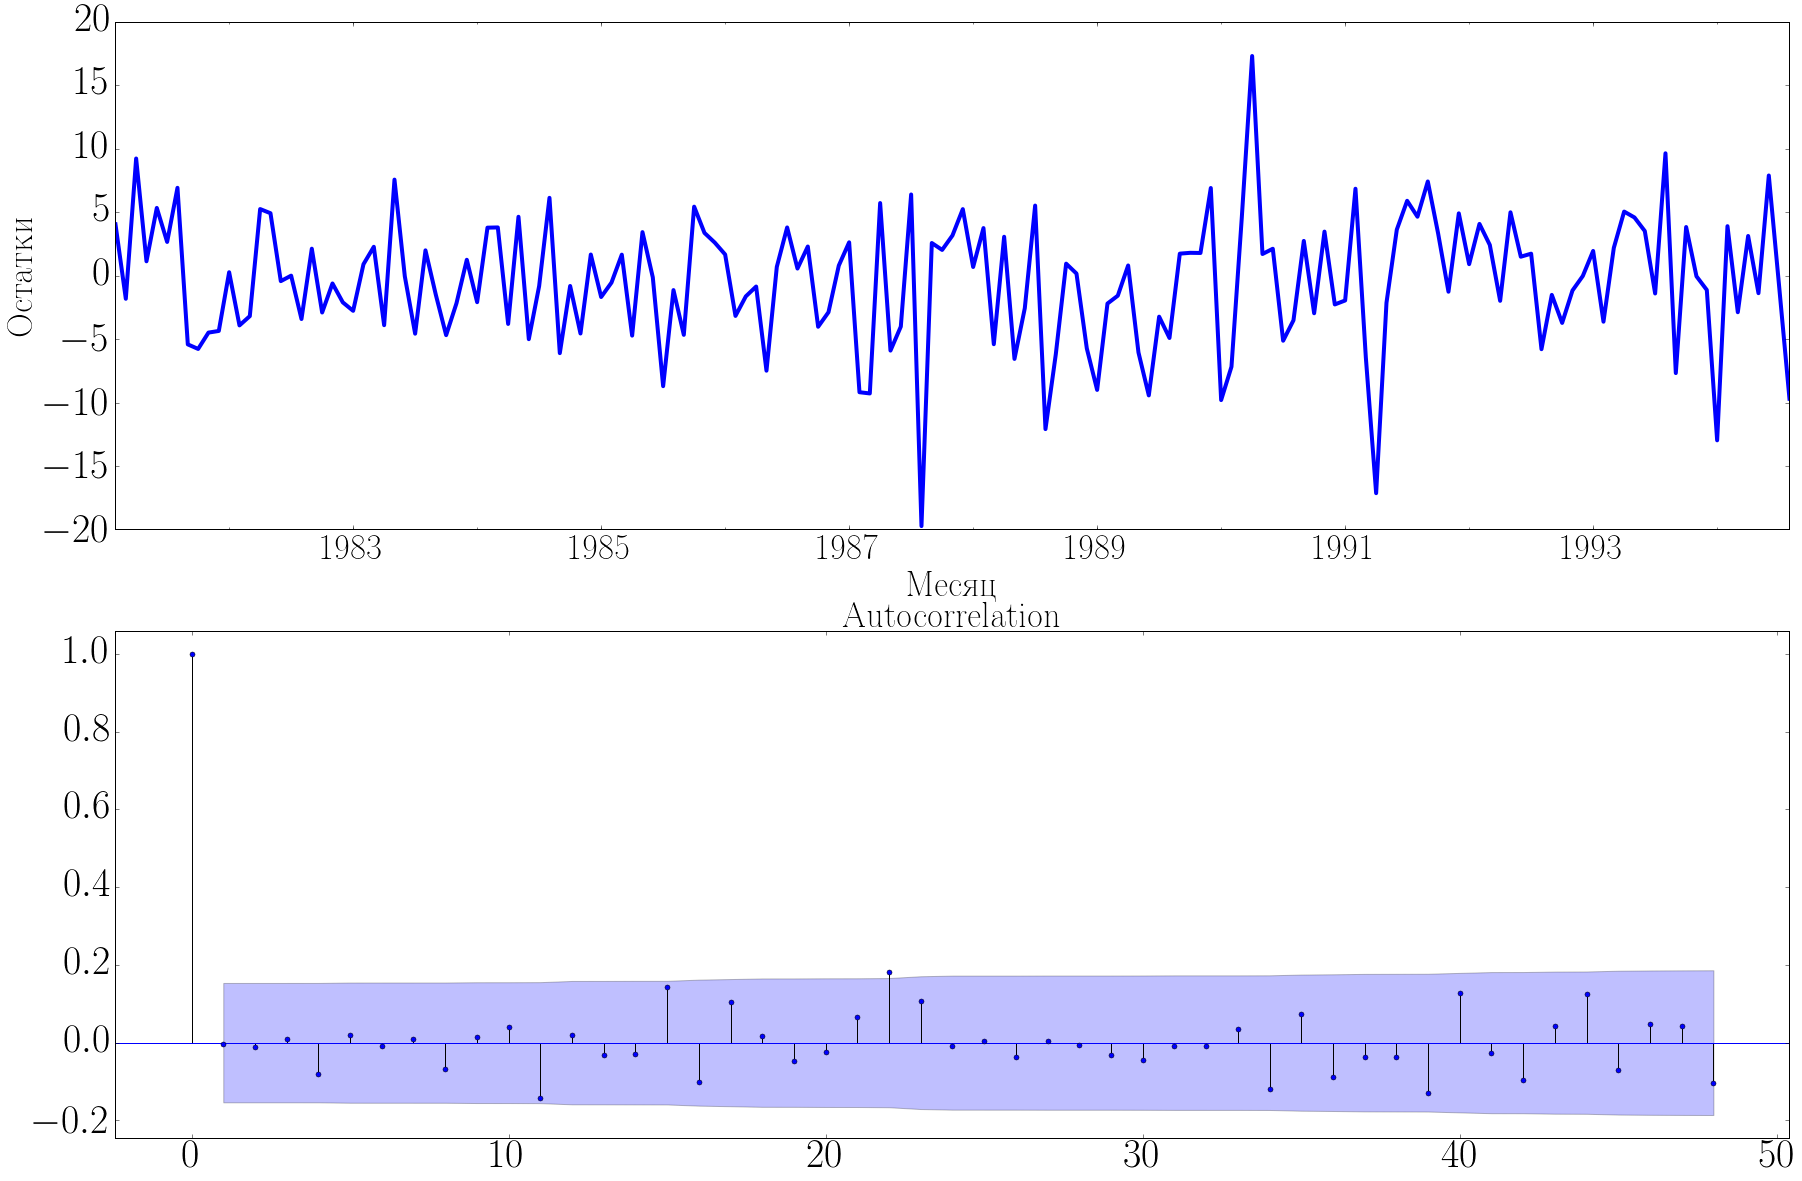

In [96]:
plt.figure(figsize(30,20))
plt.subplot(211)
model.resid[13:].plot(fontsize=40, linewidth=4.0)
plt.xlabel(u'Месяц', fontsize=60)
plt.ylabel(u'Остатки', fontsize=60)

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(model.resid[13:])[1]

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

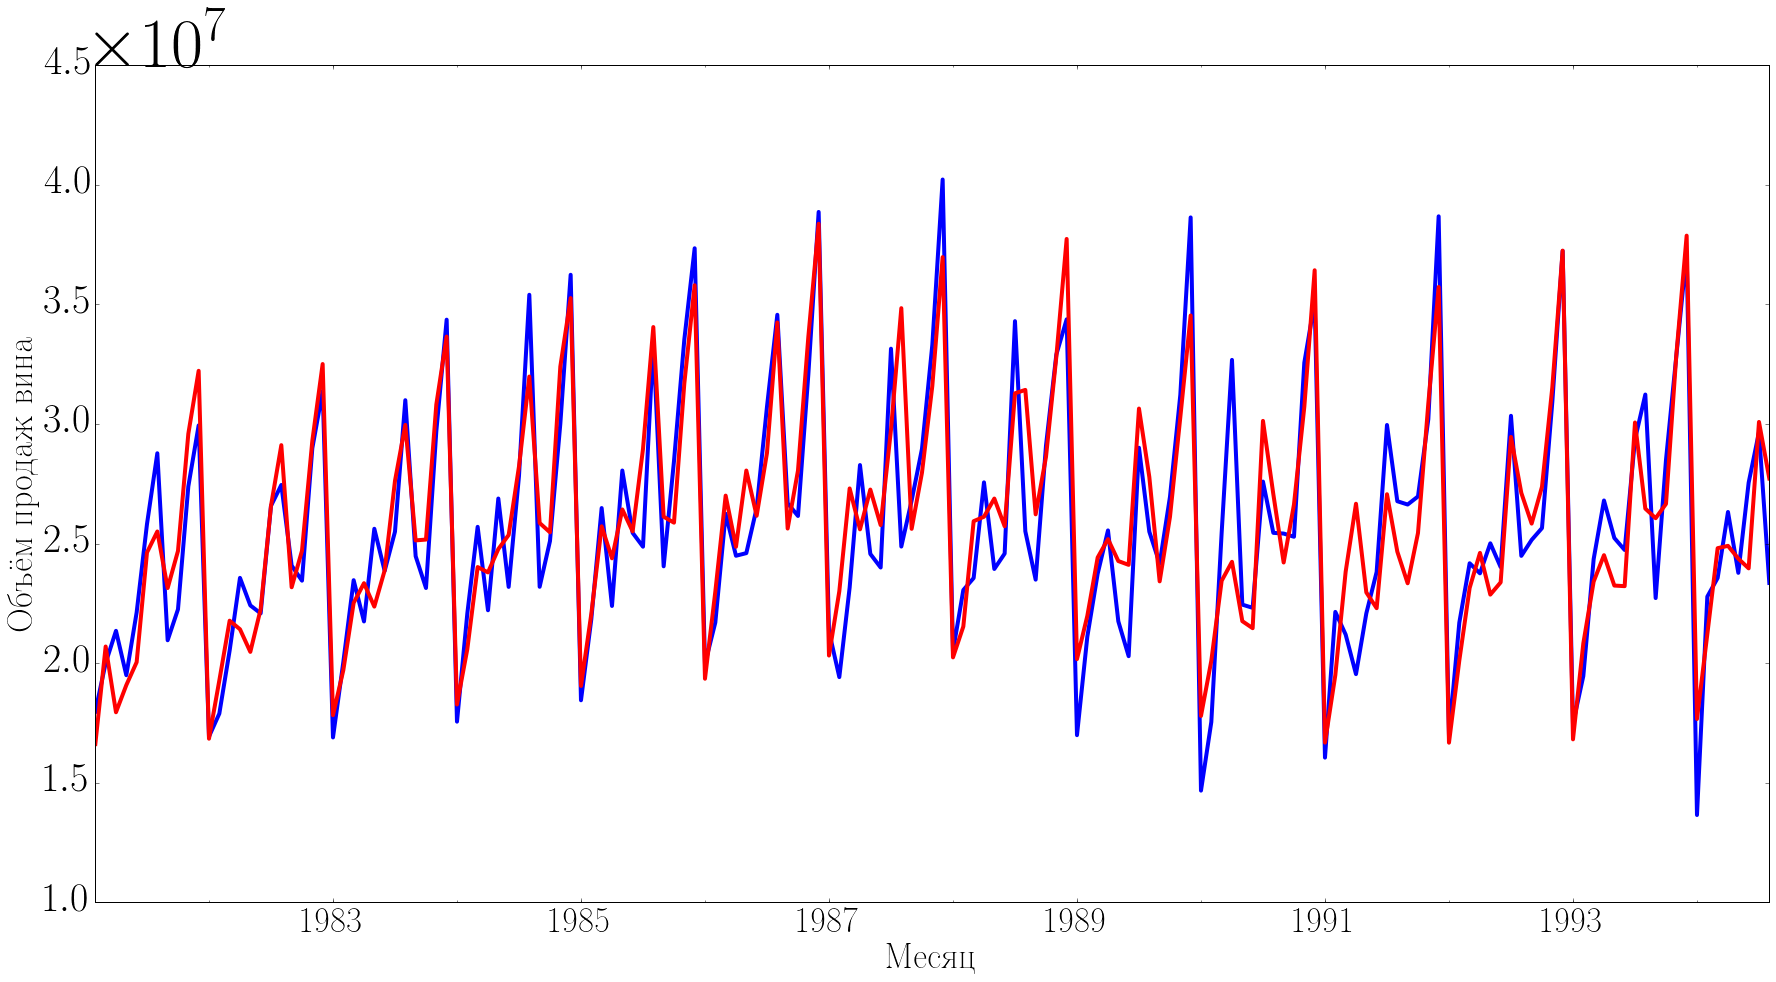

In [97]:
wine['model'] = invboxcox(model.fittedvalues, lmbda)
plt.figure(figsize(30,15))
wine.sales[13:].plot(fontsize=40, linewidth=4.0)
wine.model[13:].plot(fontsize=40, linewidth=4.0, color='r')
plt.xlabel(u'Месяц', fontsize=60)
plt.ylabel(u'Объём продаж вина', fontsize=60)

### Прогноз

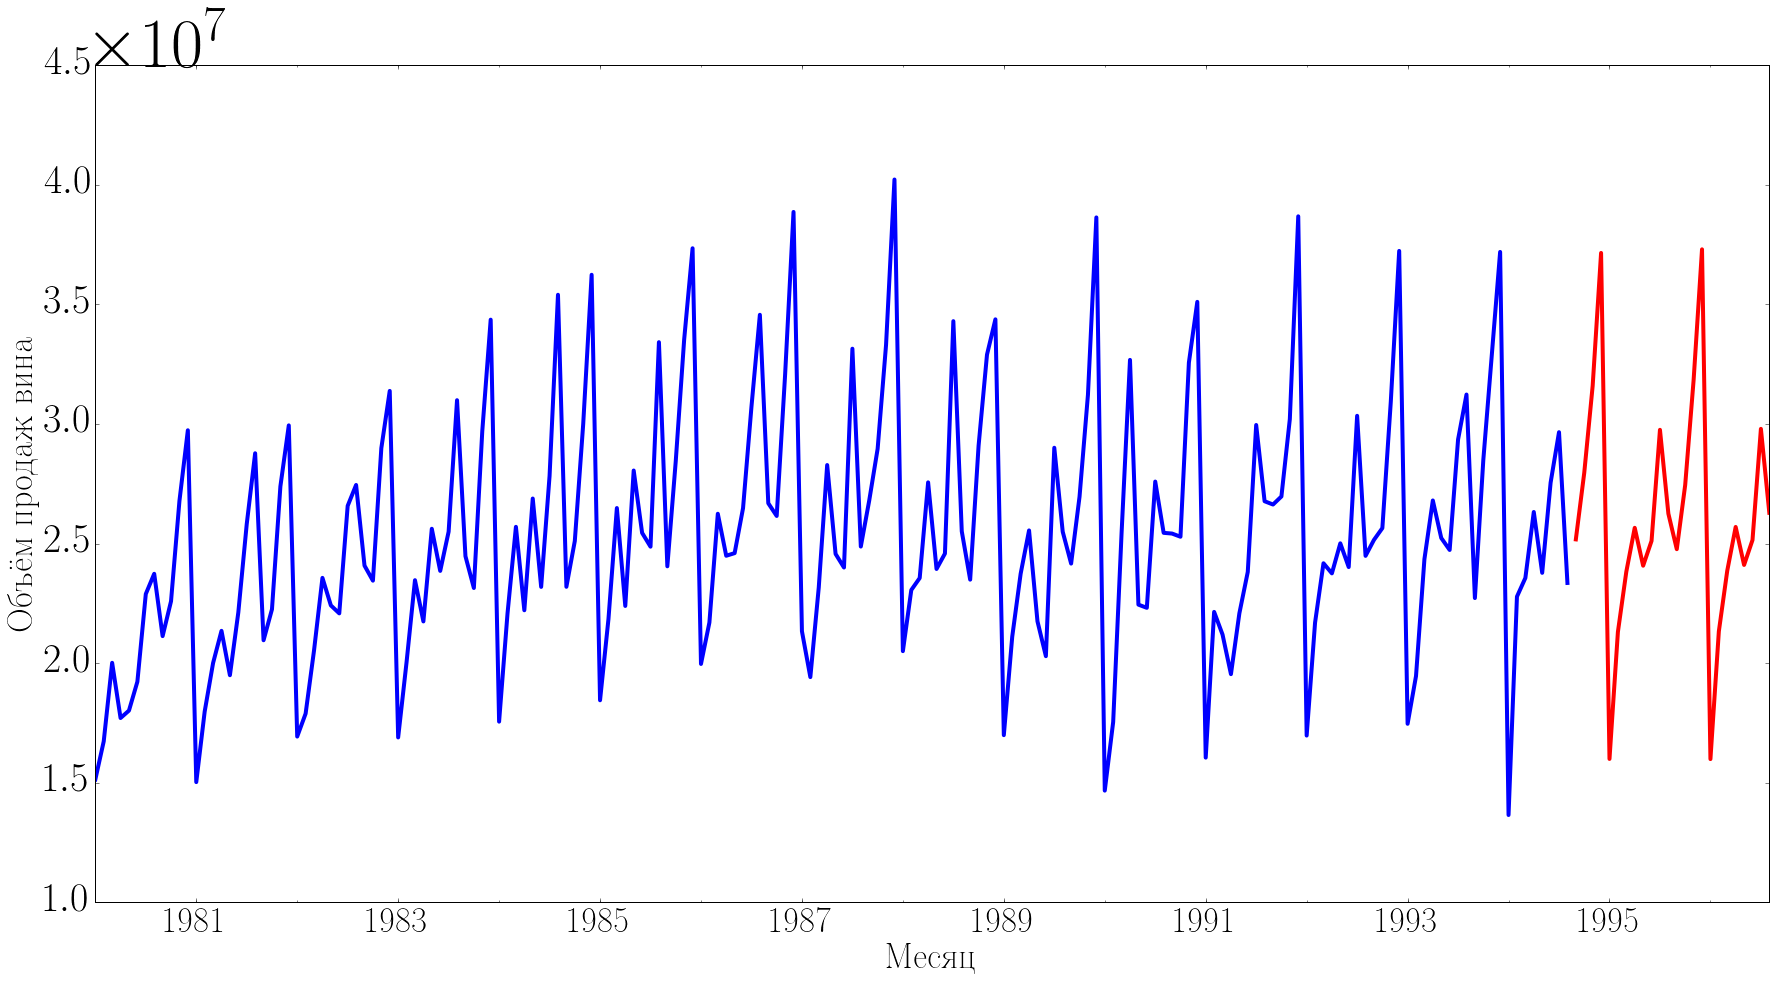

In [98]:
wine2 = wine[['sales']]
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(model.predict(start=176, end=199), lmbda)

plt.figure(figsize(30,15))
wine2.sales.plot(fontsize=40, linewidth=4.0)
wine2.forecast.plot(fontsize=40, linewidth=4.0, color='r')
plt.xlabel(u'Месяц', fontsize=60)
plt.ylabel(u'Объём продаж вина', fontsize=60)